In [1]:
import parser
import sparse_matrix
import predict
import rocchio
from tqdm.auto import tqdm

configs = {
    "k": 1.5,
    "b": 0.5,
    "ka": 100,
    "alpha": 1,
    "beta": 0.75,
    "gamma": 0.15,
    "target": 100,
    "use_rocchio": True,
    "output_path": "../prediction.csv",
    "model_path": "../model",
    "corpus_path": "../CIRB010",
    "title_weight": 1,
    "question_weight": 1,
    "concepts_weight": 1,
    "narrative_weight": 1,
    "query_path": "../queries/query-train.xml",
    "cdn": 1,
    "ctc": 1,
    "cte": 1,
    "cts": 1,
    "unigram_weight": 1,
    "bigram_weight": 1,
    "rocchio_iters": 1,
    "use_cosine": False
}

if __name__ == '__main__':
    # parser.parse_arg(configs)
    fname_to_id, id_to_fname = parser.parse_file_list(configs)
    vocab_to_id, id_to_vocab = parser.parse_vocab_list(configs)
    doc_count = len(fname_to_id)
    inverted_files, gram_to_id, gram_count, id_to_doclen = parser.parse_inverted_file(configs, doc_count)
    configs["gram_count"] = gram_count
    configs["doc_count"] = doc_count
    # Save checkpoint for notebook
    avdl = sum(id_to_doclen.values()) / len(id_to_doclen)
    corpus = {
        "fname_to_id": fname_to_id,
        "id_to_doclen": id_to_doclen,
        "id_to_fname": id_to_fname,
        "vocab_to_id": vocab_to_id,
        "id_to_vocab": id_to_vocab,
        "inverted_files": inverted_files,
        "gram_to_id": gram_to_id,
        "avdl": avdl,
    }

Reading Inverted Files: 


In [10]:
def run_func():
    print("generating sparse")
    corpus["sparse"] = sparse_matrix.gen_matrix(corpus, configs)
    configs["rocchio_iters"] = 1
    configs["use_rocchio"] = False
    configs["gamma"] = 0
    configs["query_path"] = "../queries/query-train.xml"
    print("Processing Query")
    queries = parser.parse_queries(corpus, configs, configs["query_path"])
    sparse_queries = []
    for query in queries:
        sparse_queries.append( sparse_matrix.gen_query_vector(query, corpus, configs) )
    query_responses = []
    for sparse_query in tqdm(sparse_queries):
        query_responses.append( predict.predict_query(sparse_query, corpus, configs) )
    print("Rocchio Feedback~~~")
    for query in query_responses:
        print(query[:10])
    # print("query_responses: ", query_responses)
#     query_responses = load_csv_response()
    if configs["use_rocchio"]:
        print("in rocchio")
        for _ in tqdm(range(configs["rocchio_iters"])):
            print("iterations")
            for i in tqdm(range(len(query_responses))):
                feedback_vec = rocchio.rocchio_feedback(query_responses[i], sparse_queries[i],  corpus, configs)
                print((sparse_queries[i] + feedback_vec).sum())
                response = predict.predict_query(sparse_queries[i] + feedback_vec, corpus, configs) 
                query_responses[i] = response
        print("done rocchio")
    print("something done~~~")
    predict.process_predictions(query_responses, configs, corpus)
    predict.write_predictions(query_responses, queries, configs)
    return predict.calc_MAP(query_responses, configs)

In [27]:
import numpy as np
%load_ext autoreload
%autoreload 2

ka_maps = []
for b in np.arange(1, 10, 1):
    configs["k"] = 1.5
    configs["b"] = 0.75
    configs["ka"] = 2 ** b.item()
    ka_maps.append(run_func())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
generating sparse
Processing Query



Rocchio Feedback~~~
[21266, 21207, 46159, 21704, 20787, 11124, 45433, 25109, 25662, 11382]
[45983, 3304, 3905, 3426, 3949, 25601, 26923, 28067, 25063, 3491]
[26613, 11171, 6184, 10588, 25102, 21284, 11026, 25072, 26558, 26068]
[20429, 4954, 34356, 35108, 20279, 19449, 19708, 35191, 34621, 33197]
[25296, 10371, 175, 369, 979, 21453, 25729, 11822, 26882, 689]
[38863, 14425, 7156, 43629, 2399, 22962, 35635, 45976, 39218, 2802]
[26529, 36820, 28003, 43432, 26094, 21824, 21669, 11730, 26163, 3827]
[43497, 6186, 46227, 44177, 14738, 23308, 1451, 27492, 22130, 10579]
[8420, 9371, 23939, 4358, 7509, 5234, 6793, 18959, 38465, 46722]
[46319, 24177, 6679, 3524, 3560, 25619, 12424, 26024, 10700, 22053]
something done~~~
[0.8216275439091838, 0.8328943186434508, 0.8136327065025817, 0.8537638287638287, 0.867921416406265, 0.478572917710708, 0.7305188938407405, 0.7972364454973967, 0.6505291005291005, 0.6863818570081816]
0.7533079028811437
generating sparse
Processing Query



Rocchio Feedback~~~
[21266, 21207, 46159, 21704, 20787, 11124, 45433, 25109, 11382, 25662]
[45983, 3304, 3905, 3426, 3949, 28067, 25601, 26923, 25063, 3491]
[26613, 11171, 6184, 10588, 11026, 25102, 21284, 25072, 26558, 26068]
[4954, 20429, 34356, 35108, 20279, 19449, 19708, 35191, 34621, 29194]
[25296, 10371, 175, 369, 979, 21453, 25729, 11822, 26882, 10178]
[38863, 7156, 14425, 43629, 2399, 22962, 35635, 45976, 2239, 2802]
[26529, 36820, 28003, 43432, 21824, 26094, 21669, 11730, 26163, 3827]
[43497, 6186, 46227, 44177, 14738, 23308, 1451, 27492, 22130, 10579]
[8420, 9371, 23939, 4358, 7509, 5234, 18959, 6793, 38465, 46722]
[46319, 24177, 3524, 3560, 6679, 25619, 12424, 26024, 10700, 22053]
something done~~~
[0.8135784653387149, 0.8331659424444864, 0.8136552132095803, 0.8649871733205066, 0.8693644178492663, 0.5233590871845456, 0.7319541644085126, 0.8001016358625871, 0.6831770081770082, 0.6914838290738325]
0.762482693686904
generating sparse
Processing Query



Rocchio Feedback~~~
[21266, 21207, 46159, 21704, 20787, 45433, 11124, 11382, 25109, 25766]
[45983, 3304, 3905, 3426, 3949, 28067, 26923, 25601, 25063, 3491]
[26613, 11171, 6184, 10588, 11026, 26558, 25072, 25951, 25102, 26068]
[4954, 20429, 34356, 35108, 20279, 19449, 19708, 35191, 34621, 29194]
[25296, 10371, 175, 369, 979, 21453, 25729, 11822, 26882, 10178]
[38863, 7156, 14425, 43629, 2399, 22962, 35635, 45976, 2239, 2802]
[26529, 36820, 28003, 43432, 21824, 26094, 21669, 11730, 26163, 3827]
[43497, 6186, 46227, 44177, 14738, 23308, 1451, 27492, 22130, 10579]
[8420, 9371, 23939, 4358, 7509, 5234, 18959, 6793, 46722, 38465]
[46319, 24177, 3524, 3560, 6679, 25619, 12424, 26024, 22053, 10700]
something done~~~
[0.8052791121864206, 0.8335125743700657, 0.8148064312725631, 0.8649871733205066, 0.8693644178492663, 0.5678571420460703, 0.7320042983328859, 0.8001016358625871, 0.7008537758537758, 0.6901593024967807]
0.7678925863590922
generating sparse
Processing Query



Rocchio Feedback~~~
[21266, 21207, 46159, 20787, 21704, 45433, 11124, 11382, 25766, 25109]
[45983, 3304, 3905, 3426, 3949, 28067, 26923, 25601, 25063, 3491]
[26613, 11171, 10588, 6184, 11026, 26558, 25072, 25951, 26068, 25102]
[4954, 20429, 34356, 35108, 19708, 19449, 20279, 35191, 34621, 29194]
[25296, 10371, 175, 369, 979, 21453, 25729, 11822, 26882, 10178]
[38863, 7156, 14425, 43629, 22962, 2399, 35635, 45976, 2239, 2802]
[26529, 36820, 28003, 43432, 21824, 26094, 21669, 11730, 26163, 33309]
[43497, 6186, 46227, 44177, 14738, 27492, 23308, 1451, 10579, 22130]
[8420, 9371, 23939, 4358, 7509, 5234, 18959, 6793, 46722, 38465]
[46319, 24177, 3524, 3560, 6679, 25619, 12424, 26024, 22053, 10700]
something done~~~
[0.7994038055758198, 0.833468847053611, 0.8094503494458931, 0.8649871733205066, 0.8693644178492663, 0.5969391245108764, 0.7338530689093749, 0.8000769691712537, 0.7071669071669072, 0.6875810527594401]
0.7702291715762949
generating sparse
Processing Query



Rocchio Feedback~~~
[21266, 21207, 46159, 20787, 21704, 45433, 11124, 11382, 25766, 25109]
[45983, 3304, 3905, 3949, 3426, 28067, 26923, 25601, 25063, 3491]
[26613, 11171, 10588, 6184, 11026, 26558, 25072, 25951, 26068, 9473]
[4954, 20429, 34356, 35108, 19708, 19449, 20279, 35191, 34621, 29194]
[25296, 10371, 175, 369, 979, 21453, 25729, 11822, 10178, 26882]
[38863, 7156, 14425, 43629, 22962, 2399, 35635, 45976, 2239, 2802]
[26529, 36820, 28003, 43432, 21824, 26094, 21669, 11730, 26163, 33309]
[43497, 6186, 46227, 44177, 14738, 27492, 10579, 1451, 23308, 22130]
[8420, 9371, 23939, 4358, 7509, 18959, 5234, 6793, 46722, 38465]
[24177, 46319, 3524, 3560, 6679, 25619, 26024, 12424, 22053, 10700]
something done~~~
[0.7990572022880401, 0.8333485969333609, 0.8114464049847294, 0.8649871733205066, 0.8700859185707671, 0.6154180159068199, 0.7327024679657775, 0.8009004210816622, 0.710954785954786, 0.685467182224517]
0.7724368169230966
generating sparse
Processing Query



Rocchio Feedback~~~
[21266, 46159, 21207, 20787, 21704, 45433, 11382, 11124, 25766, 25109]
[45983, 3304, 3905, 3949, 3426, 28067, 26923, 25601, 25063, 3491]
[26613, 11171, 10588, 6184, 11026, 26558, 25072, 25951, 26068, 9473]
[4954, 20429, 34356, 35108, 19708, 19449, 20279, 35191, 34621, 29194]
[25296, 10371, 175, 369, 979, 21453, 25729, 11822, 10178, 26882]
[38863, 7156, 14425, 43629, 22962, 2399, 35635, 45976, 2239, 2802]
[26529, 36820, 28003, 43432, 21824, 26094, 21669, 11730, 26163, 33309]
[43497, 6186, 46227, 44177, 14738, 27492, 10579, 1451, 23308, 22130]
[8420, 9371, 23939, 4358, 7509, 18959, 5234, 6793, 46722, 38465]
[24177, 46319, 3524, 3560, 25619, 6679, 26024, 12424, 22053, 10700]
something done~~~
[0.7970200237802734, 0.8343105978953619, 0.8120405820494947, 0.8649871733205066, 0.8700859185707671, 0.6230502806743912, 0.7329995564981602, 0.7998611825424236, 0.7134800384800385, 0.6850931336151742]
0.7732928487426591
generating sparse
Processing Query



Rocchio Feedback~~~
[21266, 46159, 21207, 20787, 21704, 45433, 11382, 11124, 25766, 25109]
[45983, 3304, 3905, 3949, 3426, 28067, 26923, 25601, 25063, 3491]
[26613, 11171, 10588, 6184, 11026, 26558, 25072, 25951, 26068, 9473]
[4954, 20429, 34356, 35108, 19708, 19449, 20279, 29194, 34621, 35191]
[25296, 10371, 175, 369, 979, 21453, 25729, 11822, 10178, 26882]
[38863, 7156, 14425, 43629, 22962, 2399, 35635, 45976, 2239, 2802]
[26529, 36820, 28003, 43432, 21824, 26094, 21669, 11730, 26163, 33309]
[43497, 6186, 46227, 44177, 14738, 27492, 10579, 1451, 22130, 23308]
[8420, 9371, 23939, 4358, 7509, 18959, 5234, 6793, 46722, 38465]
[24177, 46319, 3524, 3560, 25619, 6679, 26024, 12424, 22053, 10700]
something done~~~
[0.7976142008450386, 0.8343105978953619, 0.8120405820494947, 0.8626022126022126, 0.8700859185707671, 0.6282903948303649, 0.7333603068589105, 0.7994726821539232, 0.7134800384800385, 0.6831424916645322]
0.7734399425950644
generating sparse
Processing Query



Rocchio Feedback~~~
[21266, 46159, 21207, 20787, 21704, 45433, 11382, 11124, 25766, 25109]
[45983, 3304, 3905, 3949, 3426, 28067, 26923, 25601, 25063, 3491]
[26613, 11171, 10588, 6184, 11026, 26558, 25072, 25951, 26068, 9473]
[4954, 20429, 34356, 35108, 19708, 19449, 20279, 29194, 34621, 35191]
[25296, 10371, 175, 369, 979, 21453, 25729, 11822, 10178, 26882]
[38863, 7156, 14425, 43629, 22962, 2399, 35635, 45976, 2239, 2802]
[26529, 36820, 28003, 43432, 21824, 26094, 21669, 11730, 26163, 33309]
[43497, 6186, 46227, 44177, 14738, 27492, 10579, 22130, 1451, 23308]
[8420, 9371, 23939, 4358, 7509, 18959, 5234, 6793, 46722, 38465]
[24177, 46319, 3524, 3560, 25619, 6679, 26024, 12424, 22053, 10700]
something done~~~
[0.7969828877137255, 0.8343105978953619, 0.8120405820494947, 0.8626022126022126, 0.8700859185707671, 0.6291215782373059, 0.7336759634245671, 0.7982100558912969, 0.7122174122174122, 0.6823809075696148]
0.7731628116171758
generating sparse
Processing Query



Rocchio Feedback~~~
[21266, 46159, 21207, 20787, 21704, 45433, 11382, 11124, 25766, 22129]
[45983, 3304, 3905, 3949, 3426, 28067, 26923, 25601, 25063, 3491]
[26613, 11171, 10588, 6184, 11026, 26558, 25072, 25951, 26068, 9473]
[4954, 20429, 34356, 35108, 19708, 19449, 20279, 29194, 34621, 35191]
[25296, 10371, 175, 369, 979, 21453, 25729, 11822, 10178, 26882]
[38863, 7156, 14425, 43629, 22962, 2399, 35635, 45976, 2239, 2802]
[26529, 36820, 28003, 43432, 21824, 26094, 21669, 11730, 26163, 33309]
[43497, 6186, 46227, 44177, 14738, 27492, 10579, 22130, 1451, 23308]
[8420, 9371, 23939, 4358, 7509, 18959, 5234, 6793, 46722, 38465]
[24177, 46319, 3524, 3560, 25619, 6679, 26024, 12424, 22053, 10700]
something done~~~
[0.7969828877137255, 0.8343105978953619, 0.8120405820494947, 0.8626022126022126, 0.8700859185707671, 0.6298212153005792, 0.7333788748921845, 0.7982100558912969, 0.7134800384800385, 0.6818999070886144]
0.7732812290484276


[0.7533079028811437, 0.762482693686904, 0.7678925863590922, 0.7702291715762949, 0.7724368169230966, 0.7732928487426591, 0.7734399425950644, 0.7731628116171758, 0.7732812290484276]


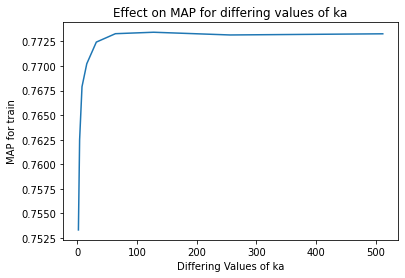

In [32]:
import matplotlib.pyplot as plt

plt.plot(2**np.arange(1, 10, 1), ka_maps)
# plt.ylim((0.77, 0.773))
plt.xlabel("Differing Values of ka")
plt.ylabel("MAP for train")
plt.title("Effect on MAP for differing values of ka")
print(ka_maps)
# k_maps = maps
